### Player Shots on Goal

This notebook trains and predict a model to predict how likely any given player is to score a goal in an NHL game. We fit XGBoost models, with Bayesian cross-validation to lessen the risk of over-fitting. Finally, we compare these predictions with historical betting odds from sportsbooks across the US.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from credentials import HOCKEY_DB_NAME, HOCKEY_DB_PWD
from schedule import get_schedule
from datetime import date
from betting_utils import convert_prob_to_american
import seaborn as sns
import requests

import datetime as dt
from datetime import date, timedelta
from pytz import timezone

import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def make_synthetic_roster(r):
    game_pk = r['game_pk']
    game_date = r['game_date']
    home_team = r['home_team']
    away_team = r['away_team']
    
    away_players = [x['roster']['roster'] for x in rosters['teams'] if x['name'] == away_team][0]
    away_players = pd.concat([make_synthetic_boxscore(x) for x in away_players])
    away_players['team'] = away_team
    away_players['opposing_team'] = home_team
    away_players['is_home_team'] = 0
    
    home_players = [x['roster']['roster'] for x in rosters['teams'] if x['name'] == home_team][0]
    home_players = pd.concat([make_synthetic_boxscore(x) for x in home_players])
    home_players['team'] = home_team
    home_players['opposing_team'] = away_team
    home_players['is_home_team'] = 1

    players = pd.concat([home_players, away_players])
    players['game_pk'] = game_pk
    players['game_date'] = game_date
    players['game_final'] = False
    
    return(players)
    
def make_synthetic_boxscore(b):
    person = b['person']
    position = b['position']
    is_goalie = position['name'] == "Goalie"
    
    return(pd.DataFrame({"player_id": person['id']
                         , "player_name": person['fullName']
                         , "position": position['name']
                         , "is_goalie": position['name'] == 'Goalie'
                         }, index = [1]))

In [3]:
s = get_schedule(startdate = date.today(), enddate = date.today())

rosters = requests.get('https://statsapi.web.nhl.com/api/v1/teams/', params={'expand': 'team.roster'}).json()

s['game_date'] = pd.to_datetime(s['game_date'])
s['game_date'] = s['game_date'].apply(lambda x: x.astimezone(timezone('US/Eastern')))
s['game_date'] = s['game_date'].apply(lambda x: x.tz_localize(None))
s

,game_pk,game_type,game_date,game_final,home_team,away_team,home_score,away_score
0,2022020346,R,2022-11-28 19:00:00,False,New York Rangers,New Jersey Devils,-1,-1
1,2022020347,R,2022-11-28 19:00:00,False,Buffalo Sabres,Tampa Bay Lightning,-1,-1
2,2022020348,R,2022-11-28 19:00:00,False,Detroit Red Wings,Toronto Maple Leafs,-1,-1
3,2022020349,R,2022-11-28 19:00:00,False,Columbus Blue Jackets,Vegas Golden Knights,-1,-1
4,2022020350,R,2022-11-28 20:00:00,False,St. Louis Blues,Dallas Stars,-1,-1
5,2022020351,R,2022-11-28 21:30:00,False,Edmonton Oilers,Florida Panthers,-1,-1


In [4]:
synth_today = pd.concat([make_synthetic_roster(a) for i, a in s.iterrows()])
synth_today

,player_id,player_name,position,is_goalie,team,opposing_team,is_home_team,game_pk,game_date,game_final
1,8470860,Jaroslav Halak,Goalie,True,New York Rangers,New Jersey Devils,1,2022020346,2022-11-28 19:00:00,False
1,8475184,Chris Kreider,Left Wing,False,New York Rangers,New Jersey Devils,1,2022020346,2022-11-28 19:00:00,False
1,8476389,Vincent Trocheck,Center,False,New York Rangers,New Jersey Devils,1,2022020346,2022-11-28 19:00:00,False
1,8476459,Mika Zibanejad,Center,False,New York Rangers,New Jersey Devils,1,2022020346,2022-11-28 19:00:00,False
1,8476624,Barclay Goodrow,Center,False,New York Rangers,New Jersey Devils,1,2022020346,2022-11-28 19:00:00,False
...,...,...,...,...,...,...,...,...,...,...
1,8479372,Josh Mahura,Defenseman,False,Florida Panthers,Edmonton Oilers,0,2022020351,2022-11-28 21:30:00,False
1,8480037,Aleksi Heponiemi,Center,False,Florida Panthers,Edmonton Oilers,0,2022020351,2022-11-28 21:30:00,False
1,8480185,Eetu Luostarinen,Center,False,Florida Panthers,Edmonton Oilers,0,2022020351,2022-11-28 21:30:00,False
1,8481519,Spencer Knight,Goalie,True,Florida Panthers,Edmonton Oilers,0,2022020351,2022-11-28 21:30:00,False


### Get real data

In [5]:
engine = create_engine('postgresql://baseball:{}@localhost:5432/{}'.format(HOCKEY_DB_PWD, HOCKEY_DB_NAME))

In [6]:
dat = pd.read_sql("""SELECT b.*, s.game_date
, CASE WHEN b.team = s.home_team THEN 1 ELSE 0 END AS is_home_team
, True AS game_final
FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2019-06-01';""", engine)

In [7]:
dat.query('shot_attempts > shots')

,player_id,player_name,position,is_goalie,assists,goals,shots,shot_attempts,plus_minus,shots_against,...,short_handed_save_percentage,even_strength_save_percentage,team,opposing_team,opposing_goalie,game_pk,time_on_ice,game_date,is_home_team,game_final
0,8479293,Brandon Tanev,Left Wing,False,0,0,3,6,0,NaN,...,None,NaN,Pittsburgh Penguins,Buffalo Sabres,Carter Hutton,2019020007,811,2019-10-03 19:00:00,1,True
2,8480946,Dominik Kahun,Center,False,0,0,0,1,0,NaN,...,None,NaN,Pittsburgh Penguins,Buffalo Sabres,Carter Hutton,2019020007,649,2019-10-03 19:00:00,1,True
7,8471677,Jack Johnson,Defenseman,False,0,0,1,4,0,NaN,...,None,NaN,Pittsburgh Penguins,Buffalo Sabres,Carter Hutton,2019020007,846,2019-10-03 19:00:00,1,True
9,8479944,Zach Aston-Reese,Center,False,0,0,1,2,-1,NaN,...,None,NaN,Pittsburgh Penguins,Buffalo Sabres,Carter Hutton,2019020007,694,2019-10-03 19:00:00,1,True
13,8471675,Sidney Crosby,Center,False,1,0,1,2,-1,NaN,...,None,NaN,Pittsburgh Penguins,Buffalo Sabres,Carter Hutton,2019020007,1261,2019-10-03 19:00:00,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137161,8477435,Ryan Graves,Defenseman,False,0,0,6,7,0,NaN,...,None,NaN,New Jersey Devils,Buffalo Sabres,Craig Anderson,2022020327,1229,2022-11-25 20:00:00,0,True
137163,8479415,Michael McLeod,Center,False,0,0,1,2,0,NaN,...,None,NaN,New Jersey Devils,Buffalo Sabres,Craig Anderson,2022020327,881,2022-11-25 20:00:00,0,True
137165,8479414,Nathan Bastian,Right Wing,False,0,0,4,5,0,NaN,...,None,NaN,New Jersey Devils,Buffalo Sabres,Craig Anderson,2022020327,970,2022-11-25 20:00:00,0,True
137167,8479407,Jesper Bratt,Left Wing,False,1,0,2,4,1,NaN,...,None,NaN,New Jersey Devils,Buffalo Sabres,Craig Anderson,2022020327,1120,2022-11-25 20:00:00,0,True


In [8]:
dat = pd.concat([dat, synth_today]).reset_index()

In [9]:
dat = dat.sort_values(['game_date', 'game_pk', 'player_id'])

In [10]:
dat['player_l5_shots_mean'] = dat.groupby(['player_id'])['shots'].apply(lambda x: x.shift().rolling(5).mean())
dat['player_l5_gt3_shots_mean'] = dat.groupby(['player_id'])['shots'].apply(lambda x: (x.shift() >= 3).rolling(5).mean())

dat['player_l10_shots_mean'] = dat.groupby(['player_id'])['shots'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt3_shots_mean'] = dat.groupby(['player_id'])['shots'].apply(lambda x: (x.shift() >= 3).rolling(10).mean())

dat['player_l25_shots_mean'] = dat.groupby(['player_id'])['shots'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt3_shots_mean'] = dat.groupby(['player_id'])['shots'].apply(lambda x: (x.shift() >= 3).rolling(25).mean())

dat['player_l10_shot_attempts_mean'] = dat.groupby(['player_id'])['shot_attempts'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt3_shot_attempts_mean'] = dat.groupby(['player_id'])['shot_attempts'].apply(lambda x: (x.shift() >= 3).rolling(10).mean())

dat['player_l25_shot_attempts_mean'] = dat.groupby(['player_id'])['shot_attempts'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt3_shot_attempts_mean'] = dat.groupby(['player_id'])['shot_attempts'].apply(lambda x: (x.shift() >= 3).rolling(25).mean())

dat['player_l10_shots_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['shots'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt3_shots_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['shots'].apply(lambda x: (x.shift() >= 3).rolling(10).mean())

dat['player_l25_shots_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['shots'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt3_shots_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['shots'].apply(lambda x: (x.shift() >= 3).rolling(25).mean())

In [11]:
opponent = dat.groupby(['opposing_team', 'game_pk', 'game_date'])['shots'].sum().reset_index()
opponent = opponent.sort_values(['game_date', 'game_pk', 'opposing_team'])

opponent['opponent_l10_shots_mean'] = opponent.groupby(['opposing_team'])['shots'].apply(lambda x: x.shift().rolling(10).mean())
opponent['opponent_l25_shots_mean'] = opponent.groupby(['opposing_team'])['shots'].apply(lambda x: x.shift().rolling(25).mean())

#opponent

In [12]:
opp_position = dat.groupby(['opposing_team', 'game_pk', 'game_date', 'position'])['shots'].sum().reset_index()

opp_position = opp_position.sort_values(['game_date', 'game_pk', 'opposing_team', 'position'])

opp_position['opp_pos_l10_shots_mean'] = opp_position.groupby(['opposing_team', 'position'])['shots'].apply(lambda x: x.shift().rolling(10).mean())
opp_position['opp_pos_l25_shots_mean'] = opp_position.groupby(['opposing_team', 'position'])['shots'].apply(lambda x: x.shift().rolling(25).mean())

#opp_position

In [13]:
myteam = dat.groupby(['team', 'game_pk', 'game_date'])['shots'].sum().reset_index()
myteam = myteam.sort_values(['game_date', 'game_pk', 'team'])

myteam['team_l10_shots_mean'] = myteam.groupby(['team'])['shots'].apply(lambda x: x.shift().rolling(10).mean())
myteam['team_l25_shots_mean'] = myteam.groupby(['team'])['shots'].apply(lambda x: x.shift().rolling(25).mean())

#myteam

In [14]:
dat = dat.merge(myteam[['team', 'game_pk', 'game_date', 'team_l10_shots_mean', 'team_l25_shots_mean']]
                       , on = ['team', 'game_pk', 'game_date'])

dat = dat.merge(opponent[['opposing_team', 'game_pk', 'game_date', 'opponent_l10_shots_mean', 'opponent_l25_shots_mean']]
                       , on = ['opposing_team', 'game_pk', 'game_date'])

dat = dat.merge(opp_position[['opposing_team', 'position', 'game_pk', 'game_date', 'opp_pos_l10_shots_mean', 'opp_pos_l25_shots_mean']]
                       , on = ['opposing_team', 'position', 'game_pk', 'game_date'])

In [15]:
dat['sos_player_l5_shots'] = dat.groupby(['player_id'])['opponent_l10_shots_mean'].apply(lambda x: x.shift().rolling(5).mean())
dat['sos_player_l10_shots'] = dat.groupby(['player_id'])['opponent_l10_shots_mean'].apply(lambda x: x.shift().rolling(10).mean())
dat['sos_player_l25_shots'] = dat.groupby(['player_id'])['opponent_l10_shots_mean'].apply(lambda x: x.shift().rolling(25).mean())

dat['sos_player_pos_l5_shots'] = dat.groupby(['player_id'])['opp_pos_l10_shots_mean'].apply(lambda x: x.shift().rolling(5).mean())
dat['sos_player_pos_l10_shots'] = dat.groupby(['player_id'])['opp_pos_l10_shots_mean'].apply(lambda x: x.shift().rolling(10).mean())
dat['sos_player_pos_l25_shots'] = dat.groupby(['player_id'])['opp_pos_l10_shots_mean'].apply(lambda x: x.shift().rolling(25).mean())


In [16]:
dat['sog_3p'] = (dat['shots'] >= 3) * 1.0

In [17]:
dat = dat.query('player_l25_gt3_shots_mean >= 0.25')

In [18]:
train_dat = dat.query('game_final == True')

In [19]:
from statsmodels.formula.api import logit

m = logit('sog_3p ~ is_home_team +\
          player_l5_shots_mean + player_l5_gt3_shots_mean +\
          player_l10_shots_mean + player_l10_gt3_shots_mean +\
          player_l10_shot_attempts_mean + player_l10_gt3_shot_attempts_mean +\
          player_l25_shots_mean + player_l25_gt3_shots_mean +\
          player_l25_shot_attempts_mean + player_l25_gt3_shot_attempts_mean +\
          player_l10_shots_mean_homeaway + player_l10_gt3_shots_mean_homeaway +\
          player_l25_shots_mean_homeaway + player_l25_gt3_shots_mean_homeaway +\
          team_l10_shots_mean + team_l25_shots_mean +\
          opponent_l10_shots_mean + opponent_l25_shots_mean +\
          opp_pos_l10_shots_mean + opp_pos_l25_shots_mean +\
          sos_player_l5_shots + sos_player_l10_shots + sos_player_l25_shots +\
          sos_player_pos_l5_shots + sos_player_pos_l10_shots + sos_player_pos_l25_shots', data = train_dat)

In [20]:
g = m.fit()

g.summary()

Optimization terminated successfully.
         Current function value: 0.639319
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 sog_3p   No. Observations:                37559
Model:                          Logit   Df Residuals:                    37531
Method:                           MLE   Df Model:                           27
Date:                Mon, 28 Nov 2022   Pseudo R-squ.:                 0.05691
Time:                        18:18:03   Log-Likelihood:                -24012.
converged:                       True   LL-Null:                       -25461.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -2.6331      0.399     -6.593      0.000      -3.416      -1.850
is_home_team                           0.0700      0.022      3.174      0.002       0.027       0.113
player_l5_shots_mean                   0.1028      0.035      2.909      0.004       0.034       0.172
player_l5_gt3_shots_mean              -0.1325      0.119     -1.118      0.264      -0.365       0.100
player_l10_shots_mean                 -0.0357      0.079     -0.450      0.652      -0.191       0.120
player_l10_gt3_shots_mean              0.3329      0.217      1.537      0.124      -0.092       0.758
player_l10_shot_attempts_mean          0.0792      0.058      1.359      0.174      -0.035       0.193
player_l10_gt3_shot_attempts_mean     -0.0451      0.164     -0.275      0.783      -0.366       0.276
player_l25_shots_mean                  0.5169      0.101      5.143      0.000       0.320       0.714
player_l25_gt3_shots_mean              0.0959      0.318      0.302      0.763      -0.527       0.719
player_l25_shot_attempts_mean         -0.0908      0.072     -1.263      0.207      -0.232       0.050
player_l25_gt3_shot_attempts_mean     -0.1461      0.258     -0.567      0.571      -0.651       0.359
player_l10_shots_mean_homeaway        -0.0307      0.052     -0.593      0.553      -0.132       0.071
player_l10_gt3_shots_mean_homeaway    -0.3063      0.177     -1.728      0.084      -0.654       0.041
player_l25_shots_mean_homeaway         0.2826      0.069      4.122      0.000       0.148       0.417
player_l25_gt3_shots_mean_homeaway     0.6146      0.249      2.466      0.014       0.126       1.103
team_l10_shots_mean                   -0.0051      0.007     -0.768      0.443      -0.018       0.008
team_l25_shots_mean                    0.0011      0.008      0.141      0.888      -0.015       0.017
opponent_l10_shots_mean                0.0151      0.007      2.057      0.040       0.001       0.030
opponent_l25_shots_mean                0.0307      0.009      3.245      0.001       0.012       0.049
opp_pos_l10_shots_mean                -0.0198      0.013     -1.513      0.130      -0.046       0.006
opp_pos_l25_shots_mean                 0.0398      0.019      2.151      0.032       0.004       0.076
sos_player_l5_shots                    0.0079      0.014      0.584      0.559      -0.019       0.034
sos_player_l10_shots                   0.0036      0.021      0.167      0.867      -0.038       0.046
sos_player_l25_shots                  -0.0504      0.021     -2.376      0.018      -0.092      -0.009
sos_player_pos_l5_shots               -0.0626      0.027     -2.311      0.021      -0.116      -0.009
sos_player_pos_l10_shots               0.0171      0.041      0.420      0.674      -0.063       0.097
sos_player_pos_l25_shots               0.0239      0.029      0.836      0.403      -0.032       0.080
================================================

In [21]:
train_dat.head()

,index,player_id,player_name,position,is_goalie,assists,goals,shots,shot_attempts,plus_minus,...,opponent_l25_shots_mean,opp_pos_l10_shots_mean,opp_pos_l25_shots_mean,sos_player_l5_shots,sos_player_l10_shots,sos_player_l25_shots,sos_player_pos_l5_shots,sos_player_pos_l10_shots,sos_player_pos_l25_shots,sog_3p
12793,122302,8470966,Mark Giordano,Defenseman,False,0.0,0.0,1.0,3.0,-1.0,...,NaN,8.3,NaN,30.94,30.57,NaN,8.66,9.11,NaN,0.0
12797,122292,8478397,Rasmus Andersson,Defenseman,False,0.0,0.0,4.0,4.0,-1.0,...,NaN,8.3,NaN,30.94,30.57,NaN,8.66,9.11,NaN,1.0
12800,122294,8476346,Johnny Gaudreau,Left Wing,False,0.0,0.0,3.0,3.0,-1.0,...,NaN,5.0,NaN,30.94,30.57,NaN,6.56,5.98,NaN,1.0
12802,122293,8479314,Matthew Tkachuk,Left Wing,False,0.0,0.0,2.0,2.0,-1.0,...,NaN,5.0,NaN,30.94,30.57,NaN,6.56,5.98,NaN,0.0
12804,122295,8474150,Mikael Backlund,Center,False,0.0,0.0,0.0,0.0,0.0,...,NaN,11.1,NaN,30.94,30.57,NaN,11.00,10.90,NaN,0.0


In [22]:
X_train = train_dat[['is_home_team', 'player_l5_shots_mean', 'player_l5_gt3_shots_mean',
                     'player_l10_shots_mean', 'player_l10_gt3_shots_mean',
                     'player_l25_shots_mean', 'player_l25_gt3_shots_mean', 
                     'player_l10_shot_attempts_mean', 'player_l10_gt3_shot_attempts_mean',
                     'player_l25_shot_attempts_mean', 'player_l25_gt3_shot_attempts_mean',
                     'player_l10_shots_mean_homeaway', 'player_l10_gt3_shots_mean_homeaway',
                     'player_l25_shots_mean_homeaway', 'player_l25_gt3_shots_mean_homeaway',
                     'team_l10_shots_mean', 'team_l25_shots_mean',
                     'opponent_l10_shots_mean', 'opponent_l25_shots_mean',
                     'opp_pos_l10_shots_mean', 'opp_pos_l25_shots_mean',
                     'sos_player_l5_shots', 'sos_player_l10_shots', 'sos_player_l25_shots',
                     'sos_player_pos_l5_shots', 'sos_player_pos_l10_shots', 'sos_player_pos_l25_shots']]

y_train = train_dat['sog_3p']

In [23]:
from skopt import BayesSearchCV
import numpy as np
from skopt.plots import plot_objective, plot_histogram

val. score: -0.22595649632463471
best params: OrderedDict([('alpha', 2), ('gamma', 2), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 86)])


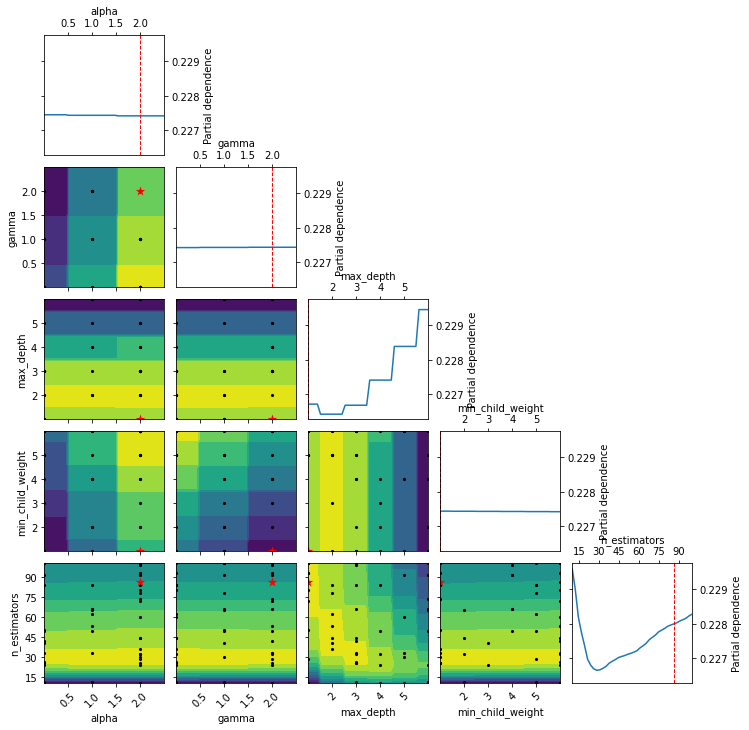

In [24]:
search1 = BayesSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1
                                                      , objective= 'binary:logistic'
                                                      , nthread=4, scale_pos_weight=1
                                                      , seed=27), 
                        search_spaces = {'n_estimators': (10, 100)
                        , 'max_depth': (1, 6)
                        , 'min_child_weight': (1, 6)
                        , 'alpha':(0, 2.5, 'uniform')
                        , 'gamma': (0, 2.5, 'uniform')}
                        , scoring='neg_brier_score',n_jobs=4, cv=5)
search1.fit(X_train,y_train)

print("val. score: %s" % search1.best_score_)
print("best params: %s" % str(search1.best_params_))

_ = plot_objective(search1.optimizer_results_[0],
                   dimensions=None,
                   n_minimum_search=int(1e8))
plt.show()

In [25]:
#xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42
#                              , max_depth = 1, min_child_weight = 6, n_estimators = 150
#                              , gamma = 0, reg_lambda = 1)
#xgb_model.fit(X_train, y_train)

y_pred_train = search1.predict_proba(X_train)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

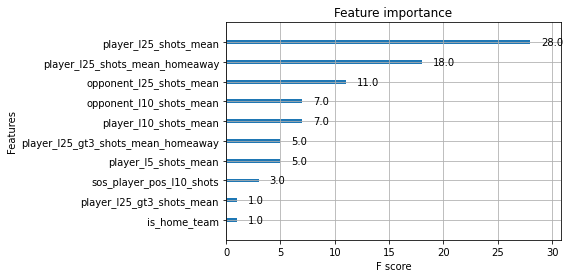

In [26]:
from xgboost import plot_importance
plot_importance(search1.best_estimator_)

In [27]:
X = dat[['is_home_team', 'player_l5_shots_mean', 'player_l5_gt3_shots_mean',
         'player_l10_shots_mean', 'player_l10_gt3_shots_mean',
         'player_l25_shots_mean', 'player_l25_gt3_shots_mean',
         'player_l10_shot_attempts_mean', 'player_l10_gt3_shot_attempts_mean',
         'player_l25_shot_attempts_mean', 'player_l25_gt3_shot_attempts_mean',
         'player_l10_shots_mean_homeaway', 'player_l10_gt3_shots_mean_homeaway',
         'player_l25_shots_mean_homeaway', 'player_l25_gt3_shots_mean_homeaway',
         'team_l10_shots_mean', 'team_l25_shots_mean',
         'opponent_l10_shots_mean', 'opponent_l25_shots_mean',
         'opp_pos_l10_shots_mean', 'opp_pos_l25_shots_mean',
         'sos_player_l5_shots', 'sos_player_l10_shots', 'sos_player_l25_shots',
         'sos_player_pos_l5_shots', 'sos_player_pos_l10_shots', 'sos_player_pos_l25_shots']]

y_pred = search1.predict_proba(X)

### logistic

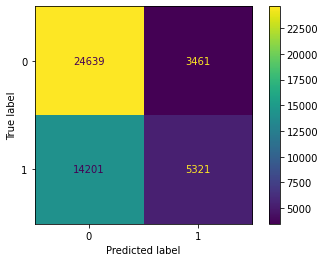

In [28]:
p = ConfusionMatrixDisplay(confusion_matrix(y_train, g.predict(exog = train_dat) >= 0.5))
p.plot()
plt.show()

### xgb

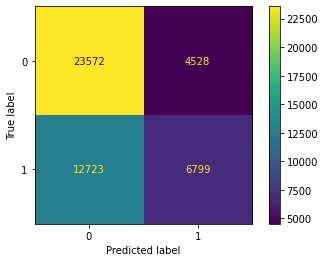

In [29]:
p = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train[:, 1] >= 0.5))
p.plot()
plt.show()

In [30]:
dat['pred_3sog'] = search1.predict_proba(X)[:, 1]
dat['odds'] = dat['pred_3sog'].apply(convert_prob_to_american)

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Get today odds

In [32]:
import requests
import json
from bs4 import BeautifulSoup
import re 

# Create an URL object
url = 'https://www.rotowire.com/betting/nhl/player-props.php'
# Create object page
page = requests.get(url)

soup = BeautifulSoup(page.text)

In [33]:
results = re.findall(pattern = 'data: (.+])', string = soup.prettify())
odds = {}
for res in results:
    try:
        records = re.sub(pattern = '},{', repl= '}***{', string=res[1:-1]).split('***')
        records_df = pd.concat([pd.DataFrame(json.loads(rec), index = [1]) for rec in records])
        odds[records_df.columns[9]] = records_df
    
        print(records_df.columns[9])
        
    except:
        pass

draftkings_firstgoal
draftkings_anygoal
draftkings_anypoint
draftkings_ast
mgm_pppt
mgm_blk
draftkings_shot
draftkings_firstgoal
draftkings_firstgoal


In [34]:
import pickle
f = open('odds_{}.pkl'.format(date.today()), 'wb')
pickle.dump(odds, f)

In [35]:
today_games = dat.query('game_final == False')

In [36]:
today_games = today_games.merge(odds['draftkings_shot'][['name', 'draftkings_shot', 'draftkings_shotOver', 'mgm_shotOver', 'fanduel_shotOver']]
                                , left_on = ['player_name'], right_on = ['name'], how='left')

In [37]:
for i, r in s.iterrows():
    print(r['away_team'])
    display(today_games.query('game_final == False & team == \"{}\"'.format(r['away_team']))[['game_date', 'player_name', 'shots', 'pred_3sog'
                                                                                              , 'odds', 'draftkings_shot', 'draftkings_shotOver'
                                                                                              , 'fanduel_shotOver', 'mgm_shotOver']].sort_values('odds'))

    print(r['home_team'])
    display(today_games.query('game_final == False & team == \"{}\"'.format(r['home_team']))[['game_date', 'player_name', 'shots', 'pred_3sog'
                                                                                              , 'odds', 'draftkings_shot', 'draftkings_shotOver'
                                                                                              , 'fanduel_shotOver', 'mgm_shotOver']].sort_values('odds'))

New Jersey Devils


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
18,2022-11-28 19:00:00,Jack Hughes,NaN,0.661873,-195.746902,3.5,-125,None,None
10,2022-11-28 19:00:00,Dougie Hamilton,NaN,0.560736,-127.653715,3.5,115,None,None
16,2022-11-28 19:00:00,Nico Hischier,NaN,0.514947,-106.163011,2.5,-140,None,None
14,2022-11-28 19:00:00,Jesper Bratt,NaN,0.399116,150.553512,2.5,110,None,None
15,2022-11-28 19:00:00,Fabian Zetterlund,NaN,0.381329,162.240619,NaN,NaN,NaN,NaN
12,2022-11-28 19:00:00,Erik Haula,NaN,0.371846,168.928671,NaN,NaN,NaN,NaN
13,2022-11-28 19:00:00,Miles Wood,NaN,0.358558,178.894907,NaN,NaN,NaN,NaN
17,2022-11-28 19:00:00,Yegor Sharangovich,NaN,0.337903,195.943264,NaN,NaN,NaN,NaN
11,2022-11-28 19:00:00,Tomas Tatar,NaN,0.247687,303.734684,NaN,NaN,NaN,NaN


New York Rangers


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
5,2022-11-28 19:00:00,Mika Zibanejad,NaN,0.607173,-154.565119,3.5,-105,None,None
0,2022-11-28 19:00:00,Chris Kreider,NaN,0.591356,-144.711945,2.5,-155,None,None
4,2022-11-28 19:00:00,Vincent Trocheck,NaN,0.550162,-122.302407,2.5,-135,None,None
7,2022-11-28 19:00:00,Jacob Trouba,NaN,0.533417,-114.324024,NaN,NaN,NaN,NaN
8,2022-11-28 19:00:00,Adam Fox,NaN,0.360311,177.538015,NaN,NaN,NaN,NaN
2,2022-11-28 19:00:00,Artemi Panarin,NaN,0.344659,190.141775,2.5,110,None,None
3,2022-11-28 19:00:00,Alexis Lafrenière,NaN,0.312585,219.913171,NaN,NaN,NaN,NaN
6,2022-11-28 19:00:00,Filip Chytil,NaN,0.266843,274.752626,NaN,NaN,NaN,NaN
9,2022-11-28 19:00:00,Kaapo Kakko,NaN,0.262261,281.300060,NaN,NaN,NaN,NaN
1,2022-11-28 19:00:00,Jimmy Vesey,NaN,0.241479,314.114004,NaN,NaN,NaN,NaN


Tampa Bay Lightning


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
27,2022-11-28 19:00:00,Nikita Kucherov,NaN,0.655671,-190.420270,3.5,-130,None,None
30,2022-11-28 19:00:00,Steven Stamkos,NaN,0.653035,-188.213694,3.5,120,None,None
31,2022-11-28 19:00:00,Brayden Point,NaN,0.463795,115.612609,2.5,-120,None,None
29,2022-11-28 19:00:00,Victor Hedman,NaN,0.411434,143.052475,2.5,-110,None,None
28,2022-11-28 19:00:00,Alex Killorn,NaN,0.242813,311.839958,NaN,NaN,NaN,NaN


Buffalo Sabres


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
21,2022-11-28 19:00:00,Tage Thompson,NaN,0.759537,-315.863745,3.5,-140,None,None
22,2022-11-28 19:00:00,Jeff Skinner,NaN,0.583689,-140.204818,2.5,-175,None,None
26,2022-11-28 19:00:00,Rasmus Dahlin,NaN,0.568907,-131.968777,2.5,-155,None,None
25,2022-11-28 19:00:00,Dylan Cozens,NaN,0.468459,113.465740,2.5,105,None,None
23,2022-11-28 19:00:00,Victor Olofsson,NaN,0.445101,124.668007,NaN,NaN,NaN,NaN
20,2022-11-28 19:00:00,Alex Tuch,NaN,0.394159,153.704462,2.5,100,None,None
19,2022-11-28 19:00:00,Kyle Okposo,NaN,0.363098,175.407699,NaN,NaN,NaN,NaN
24,2022-11-28 19:00:00,Casey Mittelstadt,NaN,0.309721,222.870739,NaN,NaN,NaN,NaN


Toronto Maple Leafs


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
39,2022-11-28 19:00:00,Auston Matthews,NaN,0.737816,-281.411927,4.5,105,None,None
36,2022-11-28 19:00:00,John Tavares,NaN,0.574789,-135.177220,2.5,-160,None,None
34,2022-11-28 19:00:00,William Nylander,NaN,0.490645,103.813438,2.5,-160,None,None
35,2022-11-28 19:00:00,Mitchell Marner,NaN,0.422064,136.931039,NaN,NaN,NaN,NaN
32,2022-11-28 19:00:00,Jake Muzzin,NaN,0.322266,210.302485,NaN,NaN,NaN,NaN
33,2022-11-28 19:00:00,Morgan Rielly,NaN,0.274141,264.775257,NaN,NaN,NaN,NaN
38,2022-11-28 19:00:00,Denis Malgin,NaN,0.238446,319.382328,NaN,NaN,NaN,NaN
37,2022-11-28 19:00:00,Alexander Kerfoot,NaN,0.215047,365.015233,NaN,NaN,NaN,NaN


Detroit Red Wings


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
46,2022-11-28 19:00:00,Dylan Larkin,NaN,0.571422,-133.329940,2.5,-165,None,None
42,2022-11-28 19:00:00,Tyler Bertuzzi,NaN,0.473748,111.082845,2.5,110,None,None
40,2022-11-28 19:00:00,David Perron,NaN,0.441702,126.396948,2.5,-115,None,None
41,2022-11-28 19:00:00,Dominik Kubalik,NaN,0.402005,148.752838,2.5,-125,None,None
45,2022-11-28 19:00:00,Filip Hronek,NaN,0.374826,166.790511,NaN,NaN,NaN,NaN
47,2022-11-28 19:00:00,Robby Fabbri,NaN,0.320097,212.405535,NaN,NaN,NaN,NaN
43,2022-11-28 19:00:00,Lucas Raymond,NaN,0.302676,230.385776,NaN,NaN,NaN,NaN
44,2022-11-28 19:00:00,Jake Walman,NaN,0.267382,273.997218,NaN,NaN,NaN,NaN
50,2022-11-28 19:00:00,Filip Zadina,NaN,0.245267,307.718805,NaN,NaN,NaN,NaN
49,2022-11-28 19:00:00,Pius Suter,NaN,0.220033,354.477704,NaN,NaN,NaN,NaN


Vegas Golden Knights


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
54,2022-11-28 19:00:00,Jack Eichel,NaN,0.699138,-232.378284,3.5,-140,None,None
53,2022-11-28 19:00:00,Jonathan Marchessault,NaN,0.648932,-184.844698,3.5,105,None,None
57,2022-11-28 19:00:00,Shea Theodore,NaN,0.469424,113.027187,2.5,-140,None,None
58,2022-11-28 19:00:00,Reilly Smith,NaN,0.444574,124.934342,2.5,-115,None,None
59,2022-11-28 19:00:00,Mark Stone,NaN,0.430627,132.219312,2.5,-120,None,None
55,2022-11-28 19:00:00,Alex Pietrangelo,NaN,0.423821,135.948666,2.5,100,None,None
60,2022-11-28 19:00:00,William Carrier,NaN,0.391571,155.381751,NaN,NaN,NaN,NaN
52,2022-11-28 19:00:00,William Karlsson,NaN,0.362369,175.961931,NaN,NaN,NaN,NaN
51,2022-11-28 19:00:00,Phil Kessel,NaN,0.326819,205.980151,NaN,NaN,NaN,NaN
56,2022-11-28 19:00:00,Brayden McNabb,NaN,0.246663,305.411523,NaN,NaN,NaN,NaN


Columbus Blue Jackets


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
63,2022-11-28 19:00:00,Patrik Laine,NaN,0.606938,-154.413024,NaN,NaN,NaN,NaN
62,2022-11-28 19:00:00,Johnny Gaudreau,NaN,0.581392,-138.887142,3.5,105,None,None
65,2022-11-28 19:00:00,Boone Jenner,NaN,0.578486,-137.240226,3.5,120,None,None
64,2022-11-28 19:00:00,Zach Werenski,NaN,0.563028,-128.847791,NaN,NaN,NaN,NaN
66,2022-11-28 19:00:00,Cole Sillinger,NaN,0.284396,251.622063,1.5,-130,None,None
61,2022-11-28 19:00:00,Gustav Nyquist,NaN,0.242879,311.727620,NaN,NaN,NaN,NaN


Dallas Stars


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
74,2022-11-28 20:00:00,Jason Robertson,NaN,0.678168,-210.720948,3.5,-135,None,None
69,2022-11-28 20:00:00,Joe Pavelski,NaN,0.462795,116.078329,2.5,105,None,None
67,2022-11-28 20:00:00,Miro Heiskanen,NaN,0.438836,127.875759,2.5,-105,None,None
73,2022-11-28 20:00:00,Mason Marchment,NaN,0.436739,128.969581,2.5,135,None,None
71,2022-11-28 20:00:00,Roope Hintz,NaN,0.395961,152.549848,2.5,115,None,None
72,2022-11-28 20:00:00,Jamie Benn,NaN,0.355962,180.928480,NaN,NaN,NaN,NaN
70,2022-11-28 20:00:00,Tyler Seguin,NaN,0.325443,207.273471,1.5,-180,None,None
68,2022-11-28 20:00:00,Nils Lundkvist,NaN,0.287524,247.797288,NaN,NaN,NaN,NaN
75,2022-11-28 20:00:00,Joel Kiviranta,NaN,0.239189,318.079559,NaN,NaN,NaN,NaN


St. Louis Blues


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
78,2022-11-28 20:00:00,Jordan Kyrou,NaN,0.570637,-132.903381,2.5,-155,None,None
76,2022-11-28 20:00:00,Justin Faulk,NaN,0.512968,-105.325143,2.5,-115,None,None
79,2022-11-28 20:00:00,Vladimir Tarasenko,NaN,0.484343,106.465193,2.5,-140,None,None
81,2022-11-28 20:00:00,Pavel Buchnevich,NaN,0.355201,181.530687,2.5,125,None,None
77,2022-11-28 20:00:00,Ryan O'Reilly,NaN,0.322743,209.844314,2.5,135,None,None
80,2022-11-28 20:00:00,Brandon Saad,NaN,0.261529,282.366602,NaN,NaN,NaN,NaN


Florida Panthers


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
92,2022-11-28 21:30:00,Matthew Tkachuk,NaN,0.634918,-173.910958,3.5,-140,None,None
83,2022-11-28 21:30:00,Aleksander Barkov,NaN,0.634268,-173.424245,NaN,NaN,NaN,NaN
88,2022-11-28 21:30:00,Aaron Ekblad,NaN,0.578501,-137.248513,2.5,-150,None,None
89,2022-11-28 21:30:00,Brandon Montour,NaN,0.573904,-134.688819,2.5,-135,None,None
85,2022-11-28 21:30:00,Sam Bennett,NaN,0.565156,-129.967362,3.5,135,None,None
82,2022-11-28 21:30:00,Carter Verhaeghe,NaN,0.558457,-126.478578,2.5,-140,None,None
90,2022-11-28 21:30:00,Gustav Forsling,NaN,0.555876,-125.162350,NaN,NaN,NaN,NaN
84,2022-11-28 21:30:00,Sam Reinhart,NaN,0.535581,-115.323019,2.5,-130,None,None
91,2022-11-28 21:30:00,Patric Hornqvist,NaN,0.402152,148.662215,NaN,NaN,NaN,NaN
86,2022-11-28 21:30:00,Anton Lundell,NaN,0.393528,154.111380,NaN,NaN,NaN,NaN


Edmonton Oilers


,game_date,player_name,shots,pred_3sog,odds,draftkings_shot,draftkings_shotOver,fanduel_shotOver,mgm_shotOver
97,2022-11-28 21:30:00,Evander Kane,NaN,0.691955,-224.628241,NaN,NaN,NaN,NaN
96,2022-11-28 21:30:00,Connor McDavid,NaN,0.686357,-218.833673,3.5,-150,None,None
98,2022-11-28 21:30:00,Zach Hyman,NaN,0.646884,-183.193078,3.5,100,None,None
95,2022-11-28 21:30:00,Leon Draisaitl,NaN,0.623959,-165.928453,3.5,110,None,None
93,2022-11-28 21:30:00,Ryan Nugent-Hopkins,NaN,0.398647,150.848207,2.5,105,None,None
99,2022-11-28 21:30:00,Evan Bouchard,NaN,0.384583,160.021614,2.5,115,None,None
94,2022-11-28 21:30:00,Mattias Janmark,NaN,0.238377,319.503892,NaN,NaN,NaN,NaN


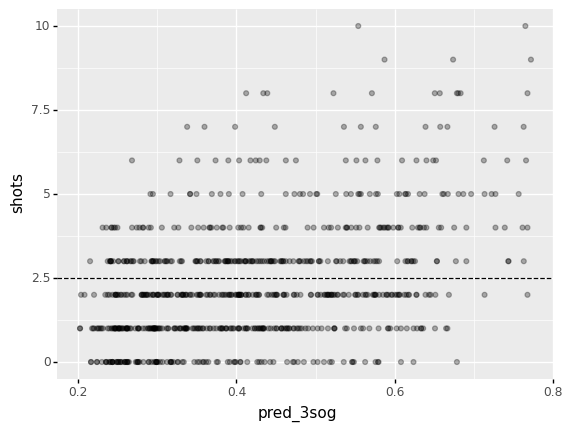

<ggplot: (154369970917)>

In [38]:
from plotnine import *
ggplot(aes(x = 'pred_3sog', y = 'shots')
       , data = dat[(dat['game_date'] >= dt.datetime.now() - dt.timedelta(days = 7)) & (dat['index'] != 1)]) +\
geom_point(alpha = 0.3) + geom_hline(aes(yintercept = 2.5), linetype = 'dashed')

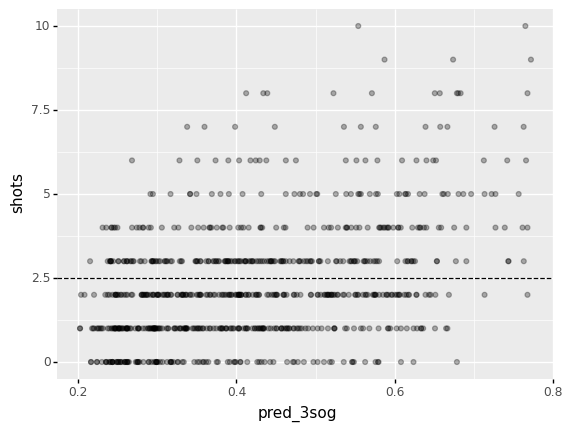

<ggplot: (154364489277)>

In [39]:
from plotnine import *
ggplot(aes(x = 'pred_3sog', y = 'shots')
       , data = dat[(dat['game_date'] >= dt.datetime.now() - dt.timedelta(days = 7)) & (dat['index'] != 1)]) +\
geom_point(alpha = 0.3) + geom_hline(aes(yintercept = 2.5), linetype = 'dashed')

In [40]:
dat[(dat['game_date'] > dt.datetime.now() - dt.timedelta(days = 2)) & (dat['index'] != 1)][['game_date', 'player_name', 'shots', 'pred_3sog', 'odds']].sort_values('odds').head(150)

,game_date,player_name,shots,pred_3sog,odds
137113,2022-11-27 20:00:00,Timo Meier,4.0,0.767799,-330.661403
136820,2022-11-26 19:00:00,Auston Matthews,6.0,0.765963,-327.282898
136925,2022-11-26 21:00:00,Nathan MacKinnon,7.0,0.762946,-321.844299
137169,2022-11-27 22:30:00,Brady Tkachuk,7.0,0.726211,-265.245182
136919,2022-11-26 21:00:00,Jason Robertson,5.0,0.722454,-260.300263
136992,2022-11-27 14:00:00,Kirill Kaprizov,5.0,0.713580,-249.138008
137034,2022-11-27 19:00:00,Kyle Connor,2.0,0.668480,-201.640528
136946,2022-11-26 22:00:00,Jack Eichel,1.0,0.666613,-199.951853
136829,2022-11-26 19:00:00,Alex Ovechkin,8.0,0.656970,-191.519814
136864,2022-11-26 19:00:00,Jack Hughes,4.0,0.655767,-190.501031


### SOG

In [41]:
def format_sog(team):
    cor_dat = pd.read_sql("""SELECT b.* FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format(team), engine)
    
    cor_dat['trimmed_sog'] = np.minimum(cor_dat['shots'], 6)

    players = cor_dat.groupby('player_name')['trimmed_sog'].sum().sort_values().tail(8).reset_index()['player_name']
    
    lvk = pd.pivot_table(cor_dat[cor_dat['player_name'].isin(players)], index = ['game_pk'], columns = 'player_name', values = ['trimmed_sog'])
    lvk.columns = [' '.join(col).strip() for col in lvk.columns.values]
    print(team)
#    display(lvk.mask(~lvk.isna(), lvk >= 2).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))
#    display(lvk.mask(~lvk.isna(), lvk >= 3).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))
#    display(lvk.mask(~lvk.isna(), lvk >= 4).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))

    corr = lvk.corr(min_periods = 12)
    display(corr.style.background_gradient(cmap = cm))


In [42]:
import numpy as np
for i in range(s.shape[0]):
    cm = sns.light_palette("blue", as_cmap=True, reverse = True)

    team_one = s.loc[i]['away_team']
    team_two = s.loc[i]['home_team']

    format_sog(team_one)
    
    format_sog(team_two)


New Jersey Devils


,trimmed_sog Damon Severson,trimmed_sog Dawson Mercer,trimmed_sog Dougie Hamilton,trimmed_sog Jack Hughes,trimmed_sog Jesper Bratt,trimmed_sog Nico Hischier,trimmed_sog Tomas Tatar,trimmed_sog Yegor Sharangovich
trimmed_sog Damon Severson,1.000000,0.130739,-0.126967,-0.103121,0.224398,-0.051539,0.034229,0.060468
trimmed_sog Dawson Mercer,0.130739,1.000000,-0.095825,-0.010518,-0.037167,-0.004266,0.087162,-0.062439
trimmed_sog Dougie Hamilton,-0.126967,-0.095825,1.000000,-0.074258,-0.125193,0.191858,-0.076705,-0.107208
trimmed_sog Jack Hughes,-0.103121,-0.010518,-0.074258,1.000000,0.068324,-0.019809,0.086733,0.175444
trimmed_sog Jesper Bratt,0.224398,-0.037167,-0.125193,0.068324,1.000000,-0.110880,0.147061,-0.052289
trimmed_sog Nico Hischier,-0.051539,-0.004266,0.191858,-0.019809,-0.110880,1.000000,0.036064,-0.181100
trimmed_sog Tomas Tatar,0.034229,0.087162,-0.076705,0.086733,0.147061,0.036064,1.000000,0.021485
trimmed_sog Yegor Sharangovich,0.060468,-0.062439,-0.107208,0.175444,-0.052289,-0.181100,0.021485,1.000000


New York Rangers


,trimmed_sog Adam Fox,trimmed_sog Alexis Lafrenière,trimmed_sog Artemi Panarin,trimmed_sog Chris Kreider,trimmed_sog Filip Chytil,trimmed_sog Jacob Trouba,trimmed_sog Mika Zibanejad,trimmed_sog Ryan Strome
trimmed_sog Adam Fox,1.000000,0.139145,0.127049,-0.092972,0.077818,-0.250974,-0.002967,0.132946
trimmed_sog Alexis Lafrenière,0.139145,1.000000,0.063680,-0.012293,0.219181,-0.013142,0.185659,-0.152028
trimmed_sog Artemi Panarin,0.127049,0.063680,1.000000,0.002672,0.139877,0.137997,0.038199,-0.108040
trimmed_sog Chris Kreider,-0.092972,-0.012293,0.002672,1.000000,-0.071157,0.141389,0.062961,0.112118
trimmed_sog Filip Chytil,0.077818,0.219181,0.139877,-0.071157,1.000000,-0.046852,0.021690,-0.176875
trimmed_sog Jacob Trouba,-0.250974,-0.013142,0.137997,0.141389,-0.046852,1.000000,0.088482,-0.143925
trimmed_sog Mika Zibanejad,-0.002967,0.185659,0.038199,0.062961,0.021690,0.088482,1.000000,0.018277
trimmed_sog Ryan Strome,0.132946,-0.152028,-0.108040,0.112118,-0.176875,-0.143925,0.018277,1.000000


Tampa Bay Lightning


,trimmed_sog Alex Killorn,trimmed_sog Brayden Point,trimmed_sog Corey Perry,trimmed_sog Mikhail Sergachev,trimmed_sog Nikita Kucherov,trimmed_sog Ross Colton,trimmed_sog Steven Stamkos,trimmed_sog Victor Hedman
trimmed_sog Alex Killorn,1.000000,-0.032741,-0.085397,0.108290,0.180488,0.234643,-0.112503,-0.001503
trimmed_sog Brayden Point,-0.032741,1.000000,-0.167154,0.068343,0.153473,0.053485,0.171652,-0.162948
trimmed_sog Corey Perry,-0.085397,-0.167154,1.000000,-0.086214,-0.188027,0.079131,0.056604,0.234916
trimmed_sog Mikhail Sergachev,0.108290,0.068343,-0.086214,1.000000,-0.038237,-0.089306,0.112459,0.127624
trimmed_sog Nikita Kucherov,0.180488,0.153473,-0.188027,-0.038237,1.000000,0.137238,-0.015062,-0.065073
trimmed_sog Ross Colton,0.234643,0.053485,0.079131,-0.089306,0.137238,1.000000,-0.015664,-0.023642
trimmed_sog Steven Stamkos,-0.112503,0.171652,0.056604,0.112459,-0.015062,-0.015664,1.000000,0.024782
trimmed_sog Victor Hedman,-0.001503,-0.162948,0.234916,0.127624,-0.065073,-0.023642,0.024782,1.000000


Buffalo Sabres


,trimmed_sog Alex Tuch,trimmed_sog Dylan Cozens,trimmed_sog Jeff Skinner,trimmed_sog Kyle Okposo,trimmed_sog Rasmus Asplund,trimmed_sog Rasmus Dahlin,trimmed_sog Tage Thompson,trimmed_sog Victor Olofsson
trimmed_sog Alex Tuch,1.000000,0.026941,-0.049313,-0.119232,0.208078,0.005848,-0.056767,0.021692
trimmed_sog Dylan Cozens,0.026941,1.000000,-0.038001,0.078619,-0.016856,0.052381,0.189709,0.047380
trimmed_sog Jeff Skinner,-0.049313,-0.038001,1.000000,0.029771,0.082906,-0.182735,0.011465,-0.044456
trimmed_sog Kyle Okposo,-0.119232,0.078619,0.029771,1.000000,0.116976,0.100785,0.188644,0.199896
trimmed_sog Rasmus Asplund,0.208078,-0.016856,0.082906,0.116976,1.000000,-0.129820,0.094347,0.117685
trimmed_sog Rasmus Dahlin,0.005848,0.052381,-0.182735,0.100785,-0.129820,1.000000,0.135972,0.037599
trimmed_sog Tage Thompson,-0.056767,0.189709,0.011465,0.188644,0.094347,0.135972,1.000000,0.105099
trimmed_sog Victor Olofsson,0.021692,0.047380,-0.044456,0.199896,0.117685,0.037599,0.105099,1.000000


Toronto Maple Leafs


,trimmed_sog Alexander Kerfoot,trimmed_sog Auston Matthews,trimmed_sog John Tavares,trimmed_sog Michael Bunting,trimmed_sog Mitchell Marner,trimmed_sog Morgan Rielly,trimmed_sog Pierre Engvall,trimmed_sog William Nylander
trimmed_sog Alexander Kerfoot,1.000000,-0.036760,-0.028618,-0.034999,-0.135881,-0.108872,-0.033314,-0.127722
trimmed_sog Auston Matthews,-0.036760,1.000000,0.310045,-0.057237,0.303802,0.071521,-0.080959,0.205639
trimmed_sog John Tavares,-0.028618,0.310045,1.000000,-0.027577,0.398370,-0.032947,0.071695,0.154825
trimmed_sog Michael Bunting,-0.034999,-0.057237,-0.027577,1.000000,0.098940,0.061538,-0.117496,-0.026401
trimmed_sog Mitchell Marner,-0.135881,0.303802,0.398370,0.098940,1.000000,0.147530,-0.095002,0.190985
trimmed_sog Morgan Rielly,-0.108872,0.071521,-0.032947,0.061538,0.147530,1.000000,-0.075591,-0.005781
trimmed_sog Pierre Engvall,-0.033314,-0.080959,0.071695,-0.117496,-0.095002,-0.075591,1.000000,-0.002513
trimmed_sog William Nylander,-0.127722,0.205639,0.154825,-0.026401,0.190985,-0.005781,-0.002513,1.000000


Detroit Red Wings


,trimmed_sog Dylan Larkin,trimmed_sog Filip Hronek,trimmed_sog Filip Zadina,trimmed_sog Lucas Raymond,trimmed_sog Michael Rasmussen,trimmed_sog Moritz Seider,trimmed_sog Pius Suter,trimmed_sog Tyler Bertuzzi
trimmed_sog Dylan Larkin,1.000000,0.026552,0.029727,0.036869,0.053357,0.152061,0.079017,0.118339
trimmed_sog Filip Hronek,0.026552,1.000000,0.058677,-0.191377,-0.118787,-0.073467,-0.210548,0.021579
trimmed_sog Filip Zadina,0.029727,0.058677,1.000000,0.046387,0.206498,0.108518,0.147650,0.080388
trimmed_sog Lucas Raymond,0.036869,-0.191377,0.046387,1.000000,0.131787,0.172006,0.106027,0.033452
trimmed_sog Michael Rasmussen,0.053357,-0.118787,0.206498,0.131787,1.000000,0.178516,-0.082527,0.194201
trimmed_sog Moritz Seider,0.152061,-0.073467,0.108518,0.172006,0.178516,1.000000,-0.039006,0.168503
trimmed_sog Pius Suter,0.079017,-0.210548,0.147650,0.106027,-0.082527,-0.039006,1.000000,0.003603
trimmed_sog Tyler Bertuzzi,0.118339,0.021579,0.080388,0.033452,0.194201,0.168503,0.003603,1.000000


Vegas Golden Knights


,trimmed_sog Alex Pietrangelo,trimmed_sog Evgenii Dadonov,trimmed_sog Jack Eichel,trimmed_sog Jonathan Marchessault,trimmed_sog Nicolas Roy,trimmed_sog Reilly Smith,trimmed_sog Shea Theodore,trimmed_sog William Karlsson
trimmed_sog Alex Pietrangelo,1.000000,-0.064032,0.082820,0.292479,-0.030427,0.116871,0.264807,-0.134951
trimmed_sog Evgenii Dadonov,-0.064032,1.000000,0.094354,0.065786,-0.065711,0.111785,-0.042823,0.090263
trimmed_sog Jack Eichel,0.082820,0.094354,1.000000,0.177340,0.395851,-0.031763,-0.285331,0.124462
trimmed_sog Jonathan Marchessault,0.292479,0.065786,0.177340,1.000000,0.064811,0.041605,0.091866,0.076320
trimmed_sog Nicolas Roy,-0.030427,-0.065711,0.395851,0.064811,1.000000,0.035299,-0.018783,-0.032096
trimmed_sog Reilly Smith,0.116871,0.111785,-0.031763,0.041605,0.035299,1.000000,-0.178082,-0.033534
trimmed_sog Shea Theodore,0.264807,-0.042823,-0.285331,0.091866,-0.018783,-0.178082,1.000000,0.009590
trimmed_sog William Karlsson,-0.134951,0.090263,0.124462,0.076320,-0.032096,-0.033534,0.009590,1.000000


Columbus Blue Jackets


,trimmed_sog Boone Jenner,trimmed_sog Cole Sillinger,trimmed_sog Gustav Nyquist,trimmed_sog Jack Roslovic,trimmed_sog Jakub Voracek,trimmed_sog Oliver Bjorkstrand,trimmed_sog Patrik Laine,trimmed_sog Zach Werenski
trimmed_sog Boone Jenner,1.000000,-0.053610,0.110691,-0.024968,0.156669,0.000000,0.021337,-0.143898
trimmed_sog Cole Sillinger,-0.053610,1.000000,0.125848,-0.017485,0.157492,0.112268,0.138460,-0.013338
trimmed_sog Gustav Nyquist,0.110691,0.125848,1.000000,0.069286,0.123458,0.318894,0.006771,0.136540
trimmed_sog Jack Roslovic,-0.024968,-0.017485,0.069286,1.000000,-0.051543,0.066505,0.061198,0.012509
trimmed_sog Jakub Voracek,0.156669,0.157492,0.123458,-0.051543,1.000000,0.250609,0.094597,0.112923
trimmed_sog Oliver Bjorkstrand,0.000000,0.112268,0.318894,0.066505,0.250609,1.000000,0.099258,0.100770
trimmed_sog Patrik Laine,0.021337,0.138460,0.006771,0.061198,0.094597,0.099258,1.000000,-0.126895
trimmed_sog Zach Werenski,-0.143898,-0.013338,0.136540,0.012509,0.112923,0.100770,-0.126895,1.000000


Dallas Stars


,trimmed_sog Denis Gurianov,trimmed_sog Esa Lindell,trimmed_sog Jamie Benn,trimmed_sog Jason Robertson,trimmed_sog Joe Pavelski,trimmed_sog Miro Heiskanen,trimmed_sog Roope Hintz,trimmed_sog Tyler Seguin
trimmed_sog Denis Gurianov,1.000000,0.048635,0.200534,-0.012358,-0.159444,0.129958,-0.094483,0.128835
trimmed_sog Esa Lindell,0.048635,1.000000,-0.006553,-0.117317,-0.028645,-0.091062,0.144629,0.157179
trimmed_sog Jamie Benn,0.200534,-0.006553,1.000000,-0.002919,0.034978,0.081821,-0.130482,0.084789
trimmed_sog Jason Robertson,-0.012358,-0.117317,-0.002919,1.000000,-0.026458,0.263103,-0.194569,0.220435
trimmed_sog Joe Pavelski,-0.159444,-0.028645,0.034978,-0.026458,1.000000,-0.122789,-0.007861,0.019531
trimmed_sog Miro Heiskanen,0.129958,-0.091062,0.081821,0.263103,-0.122789,1.000000,-0.204383,0.025448
trimmed_sog Roope Hintz,-0.094483,0.144629,-0.130482,-0.194569,-0.007861,-0.204383,1.000000,0.057451
trimmed_sog Tyler Seguin,0.128835,0.157179,0.084789,0.220435,0.019531,0.025448,0.057451,1.000000


St. Louis Blues


,trimmed_sog Brandon Saad,trimmed_sog Colton Parayko,trimmed_sog David Perron,trimmed_sog Jordan Kyrou,trimmed_sog Justin Faulk,trimmed_sog Pavel Buchnevich,trimmed_sog Ryan O'Reilly,trimmed_sog Vladimir Tarasenko
trimmed_sog Brandon Saad,1.000000,-0.042174,0.047183,-0.002580,-0.016812,0.128425,0.233654,0.303085
trimmed_sog Colton Parayko,-0.042174,1.000000,-0.055728,0.178609,-0.042504,0.014493,0.052740,-0.125729
trimmed_sog David Perron,0.047183,-0.055728,1.000000,0.020225,-0.020149,0.096803,0.096266,0.159475
trimmed_sog Jordan Kyrou,-0.002580,0.178609,0.020225,1.000000,-0.012085,-0.101141,0.029934,-0.042826
trimmed_sog Justin Faulk,-0.016812,-0.042504,-0.020149,-0.012085,1.000000,-0.183851,-0.050916,0.007475
trimmed_sog Pavel Buchnevich,0.128425,0.014493,0.096803,-0.101141,-0.183851,1.000000,0.053848,0.007746
trimmed_sog Ryan O'Reilly,0.233654,0.052740,0.096266,0.029934,-0.050916,0.053848,1.000000,0.105944
trimmed_sog Vladimir Tarasenko,0.303085,-0.125729,0.159475,-0.042826,0.007475,0.007746,0.105944,1.000000


Florida Panthers


,trimmed_sog Aaron Ekblad,trimmed_sog Aleksander Barkov,trimmed_sog Brandon Montour,trimmed_sog Carter Verhaeghe,trimmed_sog Gustav Forsling,trimmed_sog Jonathan Huberdeau,trimmed_sog Sam Bennett,trimmed_sog Sam Reinhart
trimmed_sog Aaron Ekblad,1.000000,0.093877,-0.074791,-0.056135,0.045586,0.265814,0.098882,-0.074898
trimmed_sog Aleksander Barkov,0.093877,1.000000,0.131351,-0.016134,-0.114259,0.053530,0.090081,0.099651
trimmed_sog Brandon Montour,-0.074791,0.131351,1.000000,-0.023379,0.091710,-0.091159,0.077441,0.094831
trimmed_sog Carter Verhaeghe,-0.056135,-0.016134,-0.023379,1.000000,0.063535,0.019516,0.101538,0.119547
trimmed_sog Gustav Forsling,0.045586,-0.114259,0.091710,0.063535,1.000000,0.063554,0.051677,-0.042284
trimmed_sog Jonathan Huberdeau,0.265814,0.053530,-0.091159,0.019516,0.063554,1.000000,0.245837,0.049909
trimmed_sog Sam Bennett,0.098882,0.090081,0.077441,0.101538,0.051677,0.245837,1.000000,0.143548
trimmed_sog Sam Reinhart,-0.074898,0.099651,0.094831,0.119547,-0.042284,0.049909,0.143548,1.000000


Edmonton Oilers


,trimmed_sog Connor McDavid,trimmed_sog Darnell Nurse,trimmed_sog Evan Bouchard,trimmed_sog Evander Kane,trimmed_sog Jesse Puljujarvi,trimmed_sog Leon Draisaitl,trimmed_sog Ryan Nugent-Hopkins,trimmed_sog Zach Hyman
trimmed_sog Connor McDavid,1.000000,0.078344,-0.108752,-0.257953,-0.104161,0.209705,-0.028224,-0.021308
trimmed_sog Darnell Nurse,0.078344,1.000000,0.020796,-0.084812,0.279018,-0.123837,-0.059889,0.174823
trimmed_sog Evan Bouchard,-0.108752,0.020796,1.000000,0.199950,0.147274,0.075004,0.128188,0.038254
trimmed_sog Evander Kane,-0.257953,-0.084812,0.199950,1.000000,-0.080775,0.118887,-0.228037,0.113855
trimmed_sog Jesse Puljujarvi,-0.104161,0.279018,0.147274,-0.080775,1.000000,-0.023375,0.034635,0.104615
trimmed_sog Leon Draisaitl,0.209705,-0.123837,0.075004,0.118887,-0.023375,1.000000,-0.068692,0.086131
trimmed_sog Ryan Nugent-Hopkins,-0.028224,-0.059889,0.128188,-0.228037,0.034635,-0.068692,1.000000,-0.128706
trimmed_sog Zach Hyman,-0.021308,0.174823,0.038254,0.113855,0.104615,0.086131,-0.128706,1.000000


In [43]:
dat = pd.read_sql("""SELECT b.*, s.game_date FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format('Vegas Golden Knights'), engine)